In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import os
import sys

import tensorflow as tf
#tf.__version__

from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [2]:
#mnist = tf.keras.datasets.fashion_mnist

#(x_train, y_train), (x_test, y_test) = mnist.load_data()
## training shape is (60000, 28, 28) (60000,) 9 classes[0..9]
## test shape is (10000, 28, 28) (10000)


train = pd.read_csv("../input/fashionmnist/fashion-mnist_train.csv")
x_train = train.drop(columns = "label").to_numpy()
y_train = train["label"].to_numpy()

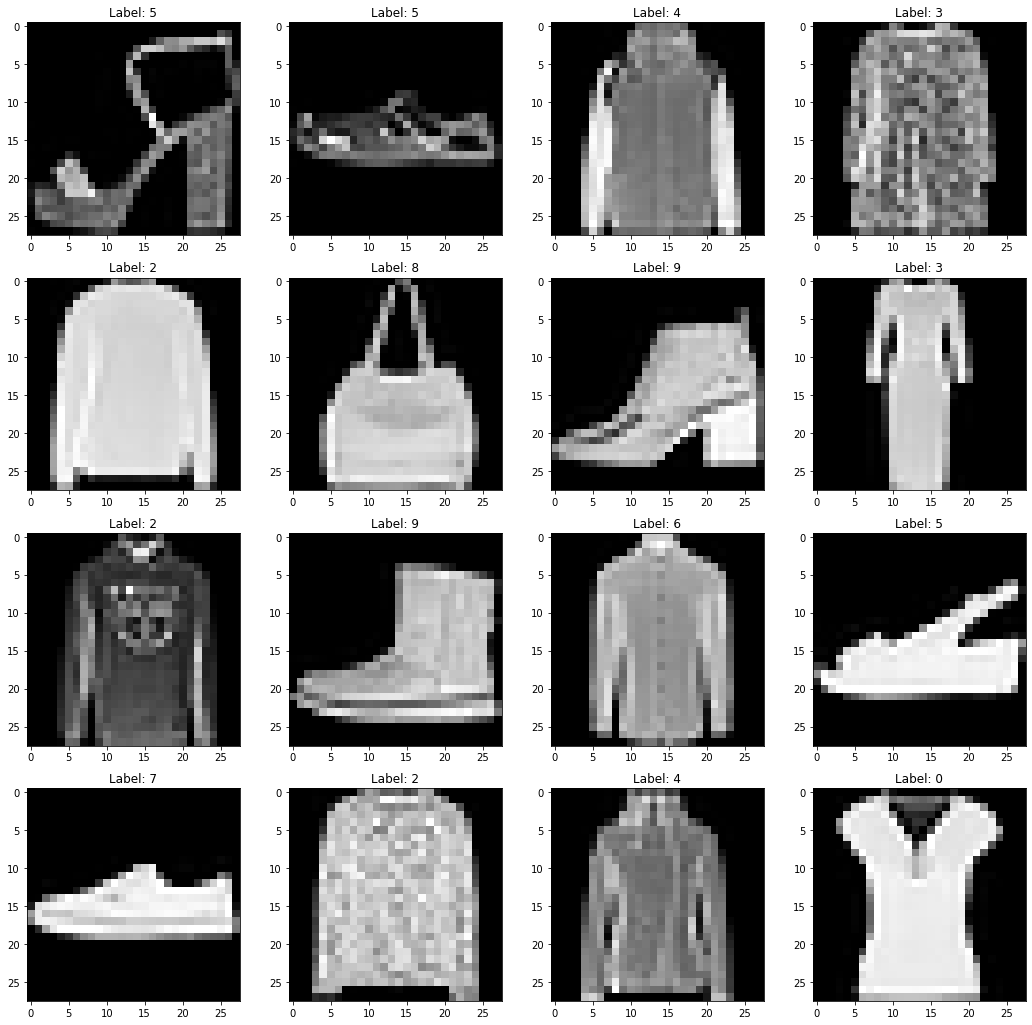

In [3]:
plt.figure(figsize=(18,18))
for i in range(16):
  idx = random.randint(0, 60000-1)

  img = x_train[idx].reshape(28,28)
  label = y_train[idx]
  
  plt.subplot(4,4,i+1)
  plt.title("Label: " + str(label))
  plt.imshow(img, cmap = "gray")

In [4]:
# Preprocessing dataset
x_train = 2*(x_train/255) - 1
#x_test = x_test/255

#n, H, W = x_train.shape
#f = H*W
n, f = x_train.shape
H = 28
W = 28
#x_train = x_train.reshape(n, f)
#x_test = x_test.reshape(x_test.shape[0], f)

In [5]:
## Latent Space Dimension
latent_dimension = 100

In [6]:
## Generator
def generator_model(latent_dimension = 100, f = 28*28):
  i = Input(shape = (latent_dimension))
  
  #x = Dense(128, activation = LeakyReLU(alpha = 0.2))(i)
  #x = BatchNormalization()(x)
  
  x = Dense(256, activation = LeakyReLU(alpha = 0.02))(i)
  x = BatchNormalization()(x)
  
  x = Dense(512, activation = LeakyReLU(alpha = 0.02))(x)
  x = BatchNormalization()(x)

  x = Dense(f, activation = "tanh")(x)

  model = Model(i, x)
  return model  

In [7]:
## Discriminator
def discriminator_model(f = 28*28):
    i = Input(shape = (f))
    x = Dense(512, activation = LeakyReLU(alpha = 0.2))(i)
    x = Dropout(0.5)(x)
    x = Dense(256, activation = LeakyReLU(alpha = 0.2))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation = LeakyReLU(alpha = 0.2))(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation = LeakyReLU(alpha = 0.2))(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation = "sigmoid")(x)
    
    model = Model(i, x)
    
    return model


In [8]:
## Creating models

discriminator = discriminator_model(f)
discriminator.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

generator = generator_model(latent_dimension = latent_dimension, f = f)

z = Input(shape = (latent_dimension))
gen_img = generator(z)
discriminator.trainable = False
disc_out = discriminator(gen_img)

combined_model = Model(z, disc_out)

combined_model.compile(loss = "binary_crossentropy", optimizer = "adam")

2022-11-02 10:35:02.717564: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               25856     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_7 (Dense)              (None, 784)               402192    
Total params: 562,704
Trainable params: 561,168
Non-trainable params: 1,536
_________________________________________________

In [10]:
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0     

In [11]:
combined_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model_1 (Functional)         (None, 784)               562704    
_________________________________________________________________
model (Functional)           (None, 1)                 574465    
Total params: 1,137,169
Trainable params: 561,168
Non-trainable params: 576,001
_________________________________________________________________


In [12]:
def sample_images(epoch, show = 0):
  rows, cols = 5, 5
  noise = np.random.randn(rows*cols, latent_dimension)

  gen_pred = generator.predict(noise)
  gen_pred = (0.5*(gen_pred) + 0.5)*255

  fig, axs = plt.subplots(rows, cols)
  idx = 0

  for i in range(rows):
    for j in range(cols):
      axs[i, j].imshow(gen_pred[idx].reshape(H, W), cmap = "gray")
      axs[i, j].axis("off")
      idx = idx + 1
  fig.savefig("gan_images/%d.png" % epoch)
  if show == 1:
        plt.show()
  plt.close()

2022-11-02 10:35:03.183683: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


epoch: 1/30000, d_loss: 0.79, d_acc: 0.44, g_loss: 0.27


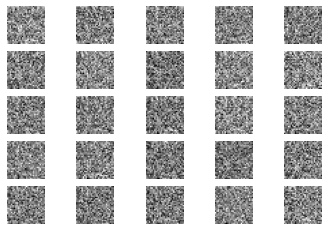

epoch: 101/30000, d_loss: 0.01, d_acc: 1.00, g_loss: 19.02
epoch: 201/30000, d_loss: 0.02, d_acc: 1.00, g_loss: 23.05
epoch: 301/30000, d_loss: 0.02, d_acc: 0.99, g_loss: 16.26
epoch: 401/30000, d_loss: 0.02, d_acc: 0.99, g_loss: 17.28
epoch: 501/30000, d_loss: 0.07, d_acc: 0.98, g_loss: 13.27


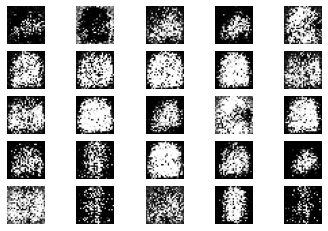

epoch: 601/30000, d_loss: 0.03, d_acc: 0.99, g_loss: 13.29
epoch: 701/30000, d_loss: 0.06, d_acc: 0.98, g_loss: 18.82
epoch: 801/30000, d_loss: 0.08, d_acc: 0.97, g_loss: 10.81
epoch: 901/30000, d_loss: 0.06, d_acc: 0.98, g_loss: 8.88
epoch: 1001/30000, d_loss: 0.04, d_acc: 0.99, g_loss: 10.78


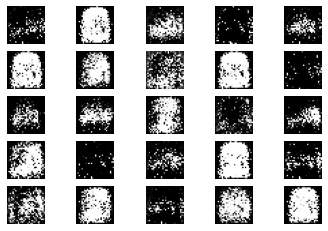

epoch: 1101/30000, d_loss: 0.14, d_acc: 0.95, g_loss: 4.79
epoch: 1201/30000, d_loss: 0.06, d_acc: 0.98, g_loss: 6.21
epoch: 1301/30000, d_loss: 0.32, d_acc: 0.88, g_loss: 3.38
epoch: 1401/30000, d_loss: 0.06, d_acc: 0.98, g_loss: 9.06
epoch: 1501/30000, d_loss: 0.07, d_acc: 0.98, g_loss: 7.87


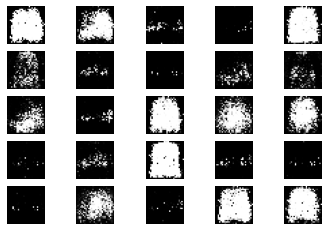

epoch: 1601/30000, d_loss: 0.19, d_acc: 0.93, g_loss: 5.54
epoch: 1701/30000, d_loss: 0.13, d_acc: 0.96, g_loss: 6.27
epoch: 1801/30000, d_loss: 0.11, d_acc: 0.96, g_loss: 6.34
epoch: 1901/30000, d_loss: 0.16, d_acc: 0.94, g_loss: 8.09
epoch: 2001/30000, d_loss: 0.16, d_acc: 0.94, g_loss: 4.71


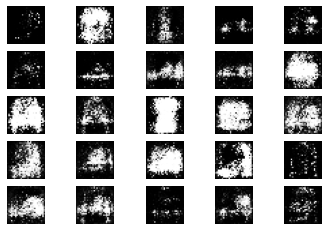

epoch: 2101/30000, d_loss: 0.21, d_acc: 0.92, g_loss: 4.55
epoch: 2201/30000, d_loss: 0.21, d_acc: 0.91, g_loss: 3.75
epoch: 2301/30000, d_loss: 0.26, d_acc: 0.90, g_loss: 3.38
epoch: 2401/30000, d_loss: 0.45, d_acc: 0.81, g_loss: 3.05
epoch: 2501/30000, d_loss: 0.24, d_acc: 0.92, g_loss: 3.42


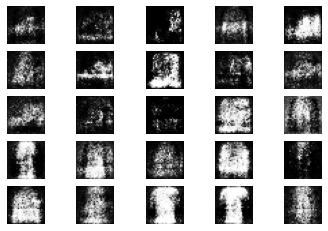

epoch: 2601/30000, d_loss: 0.36, d_acc: 0.86, g_loss: 2.50
epoch: 2701/30000, d_loss: 0.35, d_acc: 0.84, g_loss: 2.95
epoch: 2801/30000, d_loss: 0.32, d_acc: 0.87, g_loss: 2.55
epoch: 2901/30000, d_loss: 0.33, d_acc: 0.87, g_loss: 2.51
epoch: 3001/30000, d_loss: 0.39, d_acc: 0.83, g_loss: 2.33


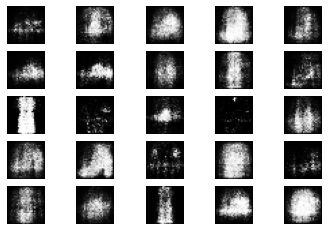

epoch: 3101/30000, d_loss: 0.18, d_acc: 0.93, g_loss: 3.46
epoch: 3201/30000, d_loss: 0.35, d_acc: 0.86, g_loss: 2.51
epoch: 3301/30000, d_loss: 0.28, d_acc: 0.88, g_loss: 2.34
epoch: 3401/30000, d_loss: 0.59, d_acc: 0.71, g_loss: 1.30
epoch: 3501/30000, d_loss: 0.40, d_acc: 0.83, g_loss: 1.64


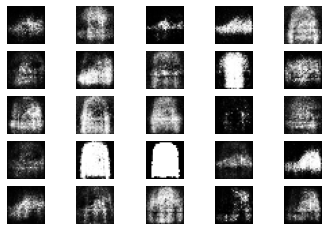

epoch: 3601/30000, d_loss: 0.43, d_acc: 0.83, g_loss: 1.55
epoch: 3701/30000, d_loss: 0.37, d_acc: 0.85, g_loss: 2.26
epoch: 3801/30000, d_loss: 0.37, d_acc: 0.86, g_loss: 1.50
epoch: 3901/30000, d_loss: 0.37, d_acc: 0.84, g_loss: 2.91
epoch: 4001/30000, d_loss: 0.34, d_acc: 0.86, g_loss: 2.58


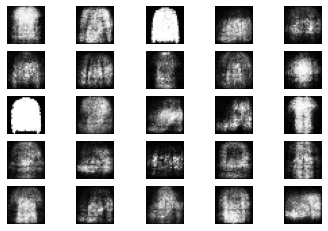

epoch: 4101/30000, d_loss: 0.47, d_acc: 0.79, g_loss: 1.17
epoch: 4201/30000, d_loss: 0.45, d_acc: 0.80, g_loss: 1.75
epoch: 4301/30000, d_loss: 0.43, d_acc: 0.82, g_loss: 1.45
epoch: 4401/30000, d_loss: 0.57, d_acc: 0.73, g_loss: 0.95
epoch: 4501/30000, d_loss: 0.26, d_acc: 0.90, g_loss: 2.67


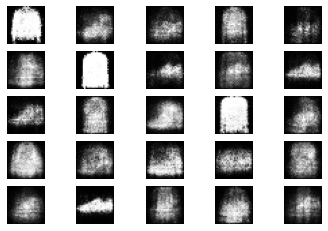

epoch: 4601/30000, d_loss: 0.37, d_acc: 0.86, g_loss: 1.58
epoch: 4701/30000, d_loss: 0.26, d_acc: 0.89, g_loss: 3.57
epoch: 4801/30000, d_loss: 0.25, d_acc: 0.90, g_loss: 2.91
epoch: 4901/30000, d_loss: 0.78, d_acc: 0.64, g_loss: 1.61
epoch: 5001/30000, d_loss: 0.30, d_acc: 0.88, g_loss: 2.55


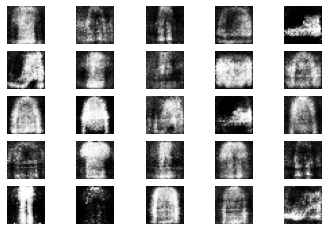

epoch: 5101/30000, d_loss: 0.54, d_acc: 0.77, g_loss: 1.88
epoch: 5201/30000, d_loss: 0.45, d_acc: 0.81, g_loss: 1.97
epoch: 5301/30000, d_loss: 0.38, d_acc: 0.84, g_loss: 1.63
epoch: 5401/30000, d_loss: 0.43, d_acc: 0.82, g_loss: 2.31
epoch: 5501/30000, d_loss: 0.56, d_acc: 0.74, g_loss: 1.94


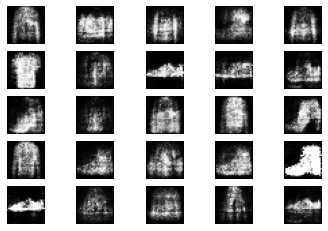

epoch: 5601/30000, d_loss: 0.31, d_acc: 0.87, g_loss: 2.87
epoch: 5701/30000, d_loss: 0.48, d_acc: 0.78, g_loss: 1.69
epoch: 5801/30000, d_loss: 0.22, d_acc: 0.92, g_loss: 2.65
epoch: 5901/30000, d_loss: 0.22, d_acc: 0.91, g_loss: 3.59
epoch: 6001/30000, d_loss: 0.34, d_acc: 0.87, g_loss: 2.22


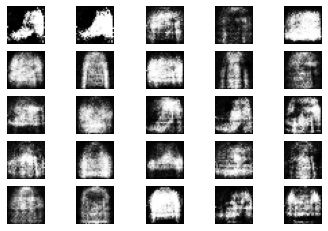

epoch: 6101/30000, d_loss: 0.31, d_acc: 0.88, g_loss: 2.75
epoch: 6201/30000, d_loss: 0.42, d_acc: 0.82, g_loss: 2.00
epoch: 6301/30000, d_loss: 0.25, d_acc: 0.89, g_loss: 2.49
epoch: 6401/30000, d_loss: 0.42, d_acc: 0.83, g_loss: 2.02
epoch: 6501/30000, d_loss: 0.38, d_acc: 0.84, g_loss: 2.03


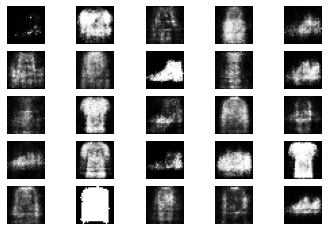

epoch: 6601/30000, d_loss: 0.38, d_acc: 0.85, g_loss: 1.63
epoch: 6701/30000, d_loss: 0.29, d_acc: 0.89, g_loss: 2.50
epoch: 6801/30000, d_loss: 0.39, d_acc: 0.85, g_loss: 1.43
epoch: 6901/30000, d_loss: 0.38, d_acc: 0.85, g_loss: 2.49
epoch: 7001/30000, d_loss: 0.36, d_acc: 0.86, g_loss: 2.38


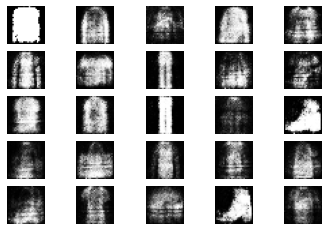

epoch: 7101/30000, d_loss: 0.30, d_acc: 0.87, g_loss: 3.19
epoch: 7201/30000, d_loss: 0.25, d_acc: 0.91, g_loss: 3.12
epoch: 7301/30000, d_loss: 0.34, d_acc: 0.85, g_loss: 3.32
epoch: 7401/30000, d_loss: 0.53, d_acc: 0.77, g_loss: 1.73
epoch: 7501/30000, d_loss: 0.30, d_acc: 0.88, g_loss: 2.19


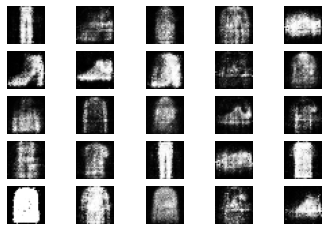

epoch: 7601/30000, d_loss: 0.30, d_acc: 0.88, g_loss: 1.93
epoch: 7701/30000, d_loss: 0.41, d_acc: 0.83, g_loss: 2.09
epoch: 7801/30000, d_loss: 0.37, d_acc: 0.84, g_loss: 2.39
epoch: 7901/30000, d_loss: 0.33, d_acc: 0.87, g_loss: 2.11
epoch: 8001/30000, d_loss: 0.28, d_acc: 0.89, g_loss: 2.18


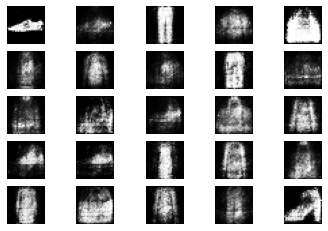

epoch: 8101/30000, d_loss: 0.35, d_acc: 0.86, g_loss: 2.35
epoch: 8201/30000, d_loss: 0.39, d_acc: 0.84, g_loss: 1.76
epoch: 8301/30000, d_loss: 0.34, d_acc: 0.88, g_loss: 1.83
epoch: 8401/30000, d_loss: 0.39, d_acc: 0.85, g_loss: 1.84
epoch: 8501/30000, d_loss: 0.38, d_acc: 0.83, g_loss: 2.51


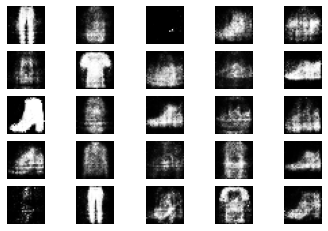

epoch: 8601/30000, d_loss: 0.36, d_acc: 0.85, g_loss: 1.70
epoch: 8701/30000, d_loss: 0.50, d_acc: 0.80, g_loss: 2.14
epoch: 8801/30000, d_loss: 0.38, d_acc: 0.84, g_loss: 2.23
epoch: 8901/30000, d_loss: 0.40, d_acc: 0.83, g_loss: 1.69
epoch: 9001/30000, d_loss: 0.23, d_acc: 0.92, g_loss: 2.23


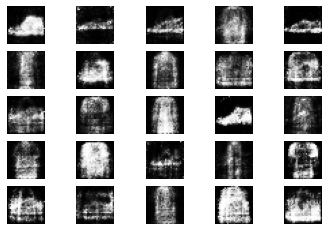

epoch: 9101/30000, d_loss: 0.27, d_acc: 0.90, g_loss: 3.49
epoch: 9201/30000, d_loss: 0.32, d_acc: 0.87, g_loss: 1.96
epoch: 9301/30000, d_loss: 0.25, d_acc: 0.90, g_loss: 2.69
epoch: 9401/30000, d_loss: 0.38, d_acc: 0.84, g_loss: 1.51
epoch: 9501/30000, d_loss: 0.41, d_acc: 0.83, g_loss: 1.94


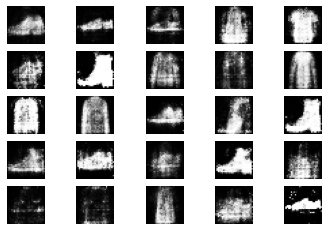

epoch: 9601/30000, d_loss: 0.39, d_acc: 0.83, g_loss: 1.91
epoch: 9701/30000, d_loss: 0.41, d_acc: 0.84, g_loss: 2.59
epoch: 9801/30000, d_loss: 0.24, d_acc: 0.91, g_loss: 2.15
epoch: 9901/30000, d_loss: 0.47, d_acc: 0.78, g_loss: 1.58
epoch: 10001/30000, d_loss: 0.33, d_acc: 0.86, g_loss: 1.95


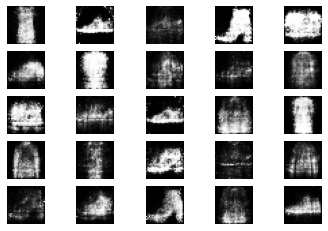

epoch: 10101/30000, d_loss: 0.33, d_acc: 0.85, g_loss: 1.87
epoch: 10201/30000, d_loss: 0.36, d_acc: 0.85, g_loss: 1.56
epoch: 10301/30000, d_loss: 0.35, d_acc: 0.86, g_loss: 1.96
epoch: 10401/30000, d_loss: 0.35, d_acc: 0.85, g_loss: 1.89
epoch: 10501/30000, d_loss: 0.46, d_acc: 0.79, g_loss: 1.34


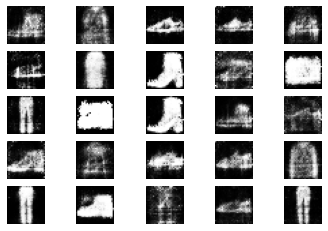

epoch: 10601/30000, d_loss: 0.31, d_acc: 0.87, g_loss: 3.15
epoch: 10701/30000, d_loss: 0.43, d_acc: 0.82, g_loss: 1.94
epoch: 10801/30000, d_loss: 0.28, d_acc: 0.90, g_loss: 1.93
epoch: 10901/30000, d_loss: 0.35, d_acc: 0.85, g_loss: 2.10
epoch: 11001/30000, d_loss: 0.42, d_acc: 0.83, g_loss: 2.32


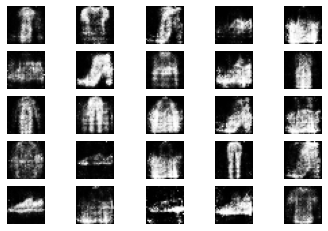

epoch: 11101/30000, d_loss: 0.31, d_acc: 0.88, g_loss: 2.38
epoch: 11201/30000, d_loss: 0.21, d_acc: 0.92, g_loss: 2.94
epoch: 11301/30000, d_loss: 0.38, d_acc: 0.85, g_loss: 2.97
epoch: 11401/30000, d_loss: 0.23, d_acc: 0.91, g_loss: 3.57
epoch: 11501/30000, d_loss: 0.29, d_acc: 0.89, g_loss: 1.81


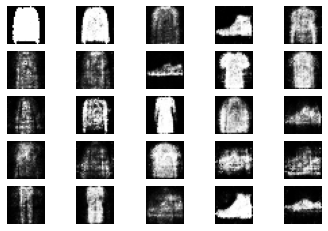

epoch: 11601/30000, d_loss: 0.40, d_acc: 0.84, g_loss: 2.20
epoch: 11701/30000, d_loss: 0.39, d_acc: 0.83, g_loss: 1.99
epoch: 11801/30000, d_loss: 0.38, d_acc: 0.85, g_loss: 2.36
epoch: 11901/30000, d_loss: 0.42, d_acc: 0.83, g_loss: 2.26
epoch: 12001/30000, d_loss: 0.26, d_acc: 0.89, g_loss: 3.11


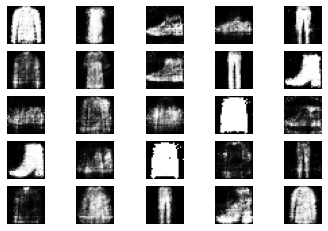

epoch: 12101/30000, d_loss: 0.35, d_acc: 0.87, g_loss: 1.99
epoch: 12201/30000, d_loss: 0.36, d_acc: 0.86, g_loss: 1.95
epoch: 12301/30000, d_loss: 0.40, d_acc: 0.83, g_loss: 1.68
epoch: 12401/30000, d_loss: 0.40, d_acc: 0.84, g_loss: 1.71
epoch: 12501/30000, d_loss: 0.56, d_acc: 0.75, g_loss: 1.92


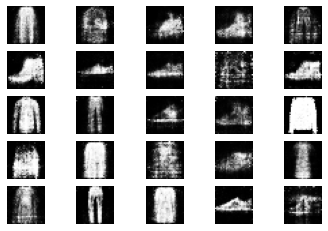

epoch: 12601/30000, d_loss: 0.40, d_acc: 0.84, g_loss: 1.92
epoch: 12701/30000, d_loss: 0.47, d_acc: 0.80, g_loss: 1.65
epoch: 12801/30000, d_loss: 0.30, d_acc: 0.87, g_loss: 2.04
epoch: 12901/30000, d_loss: 0.48, d_acc: 0.80, g_loss: 1.84
epoch: 13001/30000, d_loss: 0.58, d_acc: 0.71, g_loss: 1.09


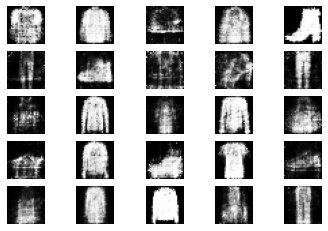

epoch: 13101/30000, d_loss: 0.40, d_acc: 0.84, g_loss: 1.54
epoch: 13201/30000, d_loss: 0.39, d_acc: 0.84, g_loss: 1.78
epoch: 13301/30000, d_loss: 0.45, d_acc: 0.80, g_loss: 1.67
epoch: 13401/30000, d_loss: 0.56, d_acc: 0.76, g_loss: 1.69
epoch: 13501/30000, d_loss: 0.22, d_acc: 0.92, g_loss: 2.23


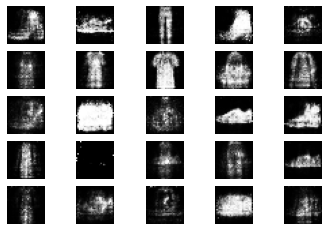

epoch: 13601/30000, d_loss: 0.37, d_acc: 0.84, g_loss: 1.68
epoch: 13701/30000, d_loss: 0.36, d_acc: 0.86, g_loss: 1.83
epoch: 13801/30000, d_loss: 0.55, d_acc: 0.74, g_loss: 1.41
epoch: 13901/30000, d_loss: 0.37, d_acc: 0.85, g_loss: 1.50
epoch: 14001/30000, d_loss: 0.40, d_acc: 0.84, g_loss: 1.59


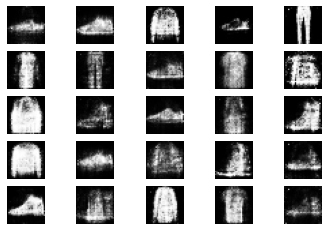

epoch: 14101/30000, d_loss: 0.37, d_acc: 0.85, g_loss: 1.72
epoch: 14201/30000, d_loss: 0.56, d_acc: 0.75, g_loss: 1.35
epoch: 14301/30000, d_loss: 0.50, d_acc: 0.78, g_loss: 1.34
epoch: 14401/30000, d_loss: 0.33, d_acc: 0.86, g_loss: 2.22
epoch: 14501/30000, d_loss: 0.40, d_acc: 0.84, g_loss: 1.63


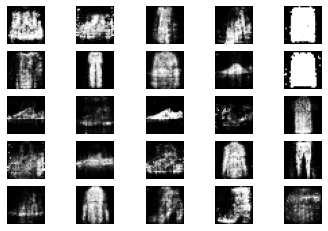

epoch: 14601/30000, d_loss: 0.40, d_acc: 0.84, g_loss: 2.23
epoch: 14701/30000, d_loss: 0.24, d_acc: 0.90, g_loss: 2.52
epoch: 14801/30000, d_loss: 0.48, d_acc: 0.77, g_loss: 1.28
epoch: 14901/30000, d_loss: 0.34, d_acc: 0.85, g_loss: 3.05
epoch: 15001/30000, d_loss: 0.35, d_acc: 0.87, g_loss: 1.71


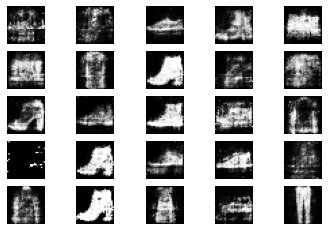

epoch: 15101/30000, d_loss: 0.50, d_acc: 0.77, g_loss: 1.26
epoch: 15201/30000, d_loss: 0.36, d_acc: 0.84, g_loss: 1.72
epoch: 15301/30000, d_loss: 0.38, d_acc: 0.86, g_loss: 1.93
epoch: 15401/30000, d_loss: 0.37, d_acc: 0.85, g_loss: 1.68
epoch: 15501/30000, d_loss: 0.30, d_acc: 0.88, g_loss: 2.48


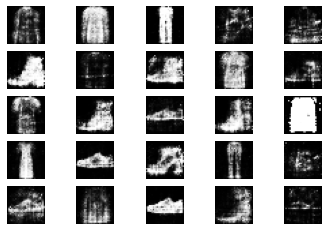

epoch: 15601/30000, d_loss: 0.35, d_acc: 0.85, g_loss: 1.83
epoch: 15701/30000, d_loss: 0.47, d_acc: 0.81, g_loss: 2.05
epoch: 15801/30000, d_loss: 0.35, d_acc: 0.86, g_loss: 2.08
epoch: 15901/30000, d_loss: 0.40, d_acc: 0.83, g_loss: 2.39
epoch: 16001/30000, d_loss: 0.44, d_acc: 0.81, g_loss: 1.64


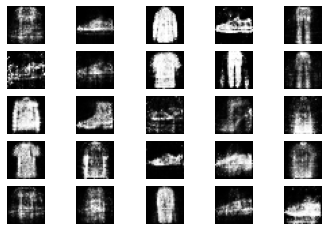

epoch: 16101/30000, d_loss: 0.47, d_acc: 0.80, g_loss: 1.48
epoch: 16201/30000, d_loss: 0.39, d_acc: 0.86, g_loss: 2.34
epoch: 16301/30000, d_loss: 0.38, d_acc: 0.86, g_loss: 2.31
epoch: 16401/30000, d_loss: 0.38, d_acc: 0.83, g_loss: 1.53
epoch: 16501/30000, d_loss: 0.39, d_acc: 0.84, g_loss: 1.94


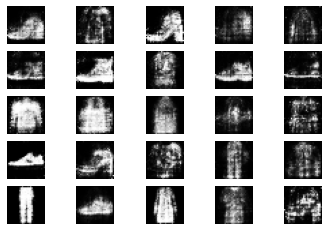

epoch: 16601/30000, d_loss: 0.35, d_acc: 0.85, g_loss: 1.85
epoch: 16701/30000, d_loss: 0.41, d_acc: 0.83, g_loss: 1.73
epoch: 16801/30000, d_loss: 0.40, d_acc: 0.82, g_loss: 1.53
epoch: 16901/30000, d_loss: 0.48, d_acc: 0.80, g_loss: 1.26
epoch: 17001/30000, d_loss: 0.50, d_acc: 0.77, g_loss: 1.41


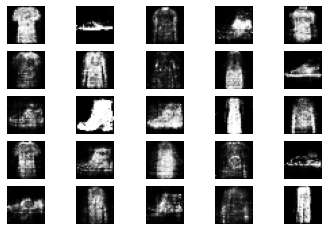

epoch: 17101/30000, d_loss: 0.29, d_acc: 0.88, g_loss: 2.61
epoch: 17201/30000, d_loss: 0.40, d_acc: 0.82, g_loss: 1.71
epoch: 17301/30000, d_loss: 0.29, d_acc: 0.89, g_loss: 2.40
epoch: 17401/30000, d_loss: 0.52, d_acc: 0.76, g_loss: 1.34
epoch: 17501/30000, d_loss: 0.40, d_acc: 0.84, g_loss: 1.85


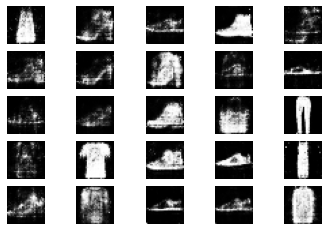

epoch: 17601/30000, d_loss: 0.49, d_acc: 0.76, g_loss: 1.42
epoch: 17701/30000, d_loss: 0.30, d_acc: 0.88, g_loss: 2.11
epoch: 17801/30000, d_loss: 0.31, d_acc: 0.88, g_loss: 2.03
epoch: 17901/30000, d_loss: 0.47, d_acc: 0.80, g_loss: 1.29
epoch: 18001/30000, d_loss: 0.42, d_acc: 0.80, g_loss: 1.51


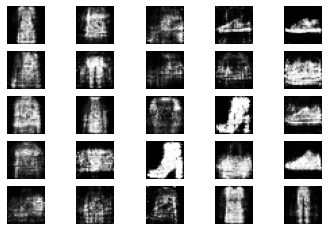

epoch: 18101/30000, d_loss: 0.36, d_acc: 0.84, g_loss: 1.81
epoch: 18201/30000, d_loss: 0.42, d_acc: 0.83, g_loss: 1.58
epoch: 18301/30000, d_loss: 0.42, d_acc: 0.81, g_loss: 1.50
epoch: 18401/30000, d_loss: 0.47, d_acc: 0.78, g_loss: 1.29
epoch: 18501/30000, d_loss: 0.63, d_acc: 0.70, g_loss: 1.57


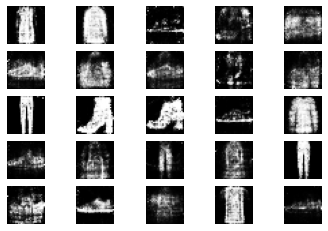

epoch: 18601/30000, d_loss: 0.39, d_acc: 0.83, g_loss: 1.95
epoch: 18701/30000, d_loss: 0.37, d_acc: 0.85, g_loss: 1.84
epoch: 18801/30000, d_loss: 0.35, d_acc: 0.87, g_loss: 1.33
epoch: 18901/30000, d_loss: 0.54, d_acc: 0.74, g_loss: 1.50
epoch: 19001/30000, d_loss: 0.48, d_acc: 0.77, g_loss: 1.34


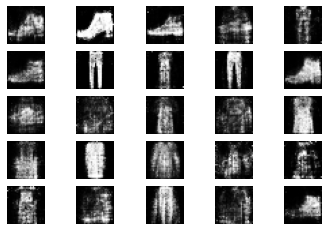

epoch: 19101/30000, d_loss: 0.40, d_acc: 0.83, g_loss: 1.73
epoch: 19201/30000, d_loss: 0.30, d_acc: 0.87, g_loss: 2.48
epoch: 19301/30000, d_loss: 0.31, d_acc: 0.88, g_loss: 2.28
epoch: 19401/30000, d_loss: 0.51, d_acc: 0.79, g_loss: 1.67
epoch: 19501/30000, d_loss: 0.53, d_acc: 0.75, g_loss: 1.15


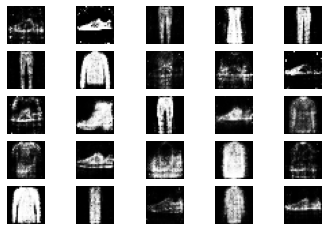

epoch: 19601/30000, d_loss: 0.49, d_acc: 0.78, g_loss: 1.50
epoch: 19701/30000, d_loss: 0.46, d_acc: 0.80, g_loss: 1.33
epoch: 19801/30000, d_loss: 0.49, d_acc: 0.78, g_loss: 1.54
epoch: 19901/30000, d_loss: 0.40, d_acc: 0.82, g_loss: 1.48
epoch: 20001/30000, d_loss: 0.21, d_acc: 0.92, g_loss: 2.93


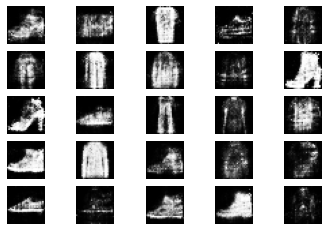

epoch: 20101/30000, d_loss: 0.41, d_acc: 0.84, g_loss: 2.36
epoch: 20201/30000, d_loss: 0.38, d_acc: 0.83, g_loss: 1.85
epoch: 20301/30000, d_loss: 0.47, d_acc: 0.79, g_loss: 1.30
epoch: 20401/30000, d_loss: 0.57, d_acc: 0.72, g_loss: 1.00
epoch: 20501/30000, d_loss: 0.40, d_acc: 0.83, g_loss: 1.67


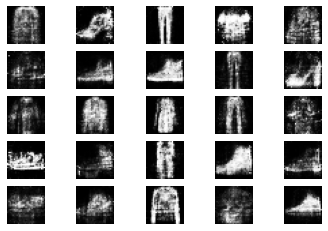

epoch: 20601/30000, d_loss: 0.39, d_acc: 0.82, g_loss: 2.04
epoch: 20701/30000, d_loss: 0.43, d_acc: 0.80, g_loss: 1.44
epoch: 20801/30000, d_loss: 0.55, d_acc: 0.72, g_loss: 1.10
epoch: 20901/30000, d_loss: 0.55, d_acc: 0.71, g_loss: 1.08
epoch: 21001/30000, d_loss: 0.54, d_acc: 0.75, g_loss: 1.12


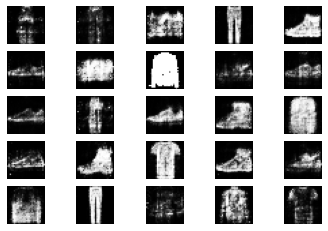

epoch: 21101/30000, d_loss: 0.35, d_acc: 0.86, g_loss: 1.62
epoch: 21201/30000, d_loss: 0.68, d_acc: 0.64, g_loss: 1.04
epoch: 21301/30000, d_loss: 0.30, d_acc: 0.90, g_loss: 2.22
epoch: 21401/30000, d_loss: 0.46, d_acc: 0.79, g_loss: 1.16
epoch: 21501/30000, d_loss: 0.52, d_acc: 0.76, g_loss: 1.62


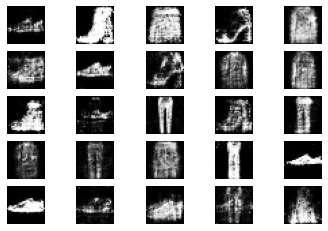

epoch: 21601/30000, d_loss: 0.58, d_acc: 0.71, g_loss: 1.00
epoch: 21701/30000, d_loss: 0.46, d_acc: 0.80, g_loss: 1.18
epoch: 21801/30000, d_loss: 0.74, d_acc: 0.66, g_loss: 1.51
epoch: 21901/30000, d_loss: 0.67, d_acc: 0.66, g_loss: 1.01
epoch: 22001/30000, d_loss: 0.65, d_acc: 0.66, g_loss: 1.18


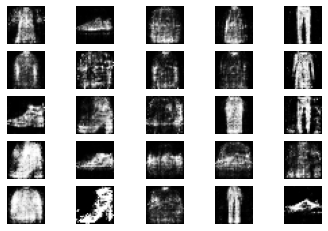

epoch: 22101/30000, d_loss: 0.37, d_acc: 0.85, g_loss: 1.58
epoch: 22201/30000, d_loss: 0.54, d_acc: 0.73, g_loss: 1.08
epoch: 22301/30000, d_loss: 0.60, d_acc: 0.67, g_loss: 1.10
epoch: 22401/30000, d_loss: 0.51, d_acc: 0.77, g_loss: 1.78
epoch: 22501/30000, d_loss: 0.40, d_acc: 0.84, g_loss: 1.35


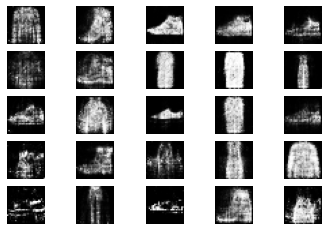

epoch: 22601/30000, d_loss: 0.26, d_acc: 0.92, g_loss: 1.95
epoch: 22701/30000, d_loss: 0.42, d_acc: 0.83, g_loss: 1.29
epoch: 22801/30000, d_loss: 0.49, d_acc: 0.77, g_loss: 1.13
epoch: 22901/30000, d_loss: 0.51, d_acc: 0.76, g_loss: 1.41
epoch: 23001/30000, d_loss: 0.37, d_acc: 0.85, g_loss: 2.44


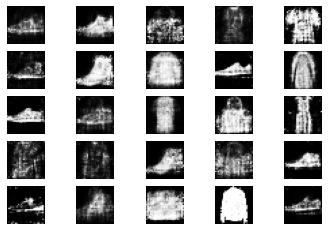

epoch: 23101/30000, d_loss: 0.50, d_acc: 0.76, g_loss: 1.13
epoch: 23201/30000, d_loss: 0.48, d_acc: 0.77, g_loss: 1.28
epoch: 23301/30000, d_loss: 0.42, d_acc: 0.81, g_loss: 1.45
epoch: 23401/30000, d_loss: 0.60, d_acc: 0.69, g_loss: 0.96
epoch: 23501/30000, d_loss: 0.54, d_acc: 0.77, g_loss: 2.00


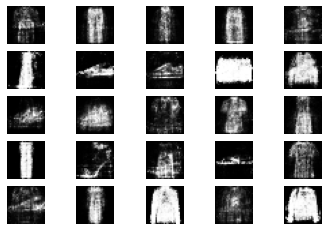

epoch: 23601/30000, d_loss: 0.39, d_acc: 0.83, g_loss: 1.63
epoch: 23701/30000, d_loss: 0.48, d_acc: 0.79, g_loss: 1.14
epoch: 23801/30000, d_loss: 0.66, d_acc: 0.66, g_loss: 1.15
epoch: 23901/30000, d_loss: 0.21, d_acc: 0.92, g_loss: 2.71
epoch: 24001/30000, d_loss: 0.38, d_acc: 0.84, g_loss: 1.45


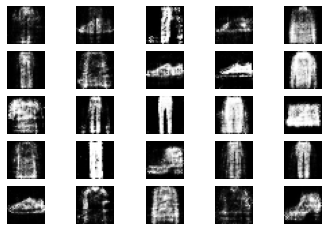

epoch: 24101/30000, d_loss: 0.42, d_acc: 0.82, g_loss: 1.37
epoch: 24201/30000, d_loss: 0.31, d_acc: 0.88, g_loss: 1.81
epoch: 24301/30000, d_loss: 0.25, d_acc: 0.90, g_loss: 2.61
epoch: 24401/30000, d_loss: 0.38, d_acc: 0.84, g_loss: 1.36
epoch: 24501/30000, d_loss: 0.57, d_acc: 0.72, g_loss: 1.23


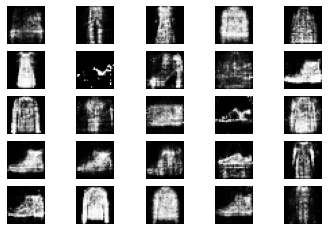

epoch: 24601/30000, d_loss: 0.46, d_acc: 0.78, g_loss: 1.65
epoch: 24701/30000, d_loss: 0.44, d_acc: 0.81, g_loss: 1.30
epoch: 24801/30000, d_loss: 0.43, d_acc: 0.82, g_loss: 1.64
epoch: 24901/30000, d_loss: 0.28, d_acc: 0.90, g_loss: 2.12
epoch: 25001/30000, d_loss: 0.57, d_acc: 0.71, g_loss: 0.98


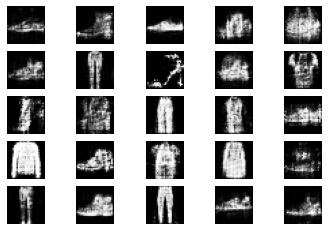

epoch: 25101/30000, d_loss: 0.27, d_acc: 0.92, g_loss: 1.87
epoch: 25201/30000, d_loss: 0.50, d_acc: 0.79, g_loss: 1.70
epoch: 25301/30000, d_loss: 0.53, d_acc: 0.74, g_loss: 1.18
epoch: 25401/30000, d_loss: 0.78, d_acc: 0.65, g_loss: 1.40
epoch: 25501/30000, d_loss: 0.30, d_acc: 0.89, g_loss: 1.91


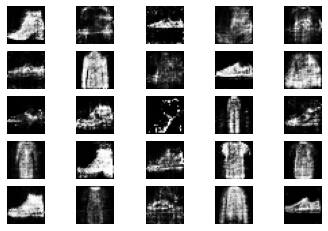

epoch: 25601/30000, d_loss: 0.72, d_acc: 0.64, g_loss: 1.31
epoch: 25701/30000, d_loss: 0.49, d_acc: 0.77, g_loss: 1.12
epoch: 25801/30000, d_loss: 0.34, d_acc: 0.86, g_loss: 2.17
epoch: 25901/30000, d_loss: 0.42, d_acc: 0.85, g_loss: 1.18
epoch: 26001/30000, d_loss: 0.81, d_acc: 0.58, g_loss: 1.19


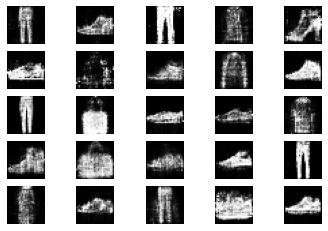

epoch: 26101/30000, d_loss: 0.70, d_acc: 0.69, g_loss: 1.64
epoch: 26201/30000, d_loss: 0.37, d_acc: 0.83, g_loss: 1.77
epoch: 26301/30000, d_loss: 0.55, d_acc: 0.72, g_loss: 1.09
epoch: 26401/30000, d_loss: 0.46, d_acc: 0.79, g_loss: 1.26
epoch: 26501/30000, d_loss: 0.67, d_acc: 0.67, g_loss: 1.27


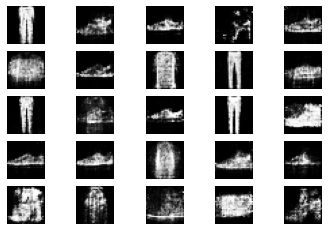

epoch: 26601/30000, d_loss: 0.32, d_acc: 0.87, g_loss: 1.98
epoch: 26701/30000, d_loss: 0.43, d_acc: 0.82, g_loss: 1.16
epoch: 26801/30000, d_loss: 0.59, d_acc: 0.70, g_loss: 1.16
epoch: 26901/30000, d_loss: 0.38, d_acc: 0.82, g_loss: 1.77
epoch: 27001/30000, d_loss: 0.40, d_acc: 0.85, g_loss: 1.28


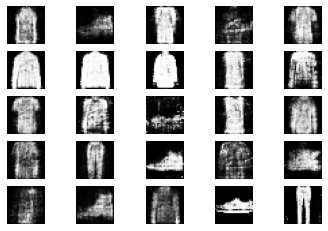

epoch: 27101/30000, d_loss: 0.60, d_acc: 0.69, g_loss: 1.22
epoch: 27201/30000, d_loss: 0.64, d_acc: 0.65, g_loss: 1.04
epoch: 27301/30000, d_loss: 0.40, d_acc: 0.84, g_loss: 1.60
epoch: 27401/30000, d_loss: 0.34, d_acc: 0.88, g_loss: 1.94
epoch: 27501/30000, d_loss: 0.41, d_acc: 0.82, g_loss: 1.49


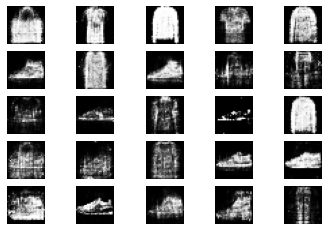

epoch: 27601/30000, d_loss: 0.42, d_acc: 0.83, g_loss: 1.23
epoch: 27701/30000, d_loss: 0.68, d_acc: 0.64, g_loss: 1.28
epoch: 27801/30000, d_loss: 0.56, d_acc: 0.72, g_loss: 1.12
epoch: 27901/30000, d_loss: 0.68, d_acc: 0.70, g_loss: 1.49
epoch: 28001/30000, d_loss: 0.43, d_acc: 0.82, g_loss: 1.48


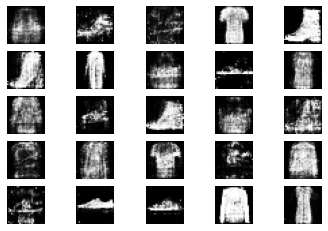

epoch: 28101/30000, d_loss: 0.52, d_acc: 0.76, g_loss: 1.26
epoch: 28201/30000, d_loss: 0.71, d_acc: 0.59, g_loss: 1.05
epoch: 28301/30000, d_loss: 0.55, d_acc: 0.74, g_loss: 1.06
epoch: 28401/30000, d_loss: 0.27, d_acc: 0.91, g_loss: 1.84
epoch: 28501/30000, d_loss: 0.58, d_acc: 0.73, g_loss: 1.53


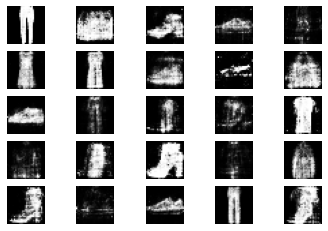

epoch: 28601/30000, d_loss: 0.49, d_acc: 0.78, g_loss: 1.12
epoch: 28701/30000, d_loss: 0.63, d_acc: 0.69, g_loss: 1.30
epoch: 28801/30000, d_loss: 0.49, d_acc: 0.79, g_loss: 1.62
epoch: 28901/30000, d_loss: 0.31, d_acc: 0.89, g_loss: 1.83
epoch: 29001/30000, d_loss: 0.39, d_acc: 0.82, g_loss: 1.74


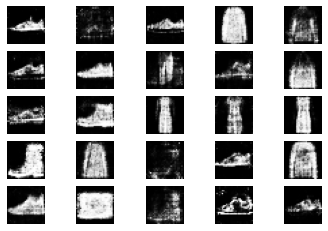

epoch: 29101/30000, d_loss: 0.27, d_acc: 0.89, g_loss: 2.02
epoch: 29201/30000, d_loss: 0.38, d_acc: 0.84, g_loss: 1.93
epoch: 29301/30000, d_loss: 0.51, d_acc: 0.78, g_loss: 1.08
epoch: 29401/30000, d_loss: 0.55, d_acc: 0.75, g_loss: 1.59
epoch: 29501/30000, d_loss: 0.39, d_acc: 0.81, g_loss: 1.86


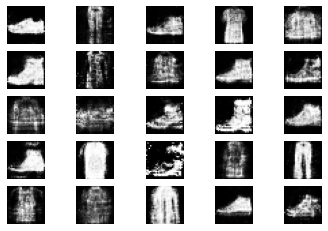

epoch: 29601/30000, d_loss: 0.32, d_acc: 0.85, g_loss: 1.83
epoch: 29701/30000, d_loss: 0.57, d_acc: 0.73, g_loss: 1.13
epoch: 29801/30000, d_loss: 0.53, d_acc: 0.72, g_loss: 1.31
epoch: 29901/30000, d_loss: 0.86, d_acc: 0.62, g_loss: 1.64


In [13]:
batch_size = 512
epochs = 30000
sample_period = 500

## Create labels
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

disc_losses = []
gen_losses = []

if not os.path.exists("gan_images"):
  os.mkdir("gan_images")



## Training

for epoch in range(epochs):

  #### Train Discriminator
  
  # Sample a batch of True images
  idx = np.random.randint(0, n, batch_size)
  real_imgs = x_train[idx]

  # Sample noise
  noise = np.random.randn(batch_size, latent_dimension)
  gen_imgs = generator.predict(noise)

  # Training discriminator
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_noise, d_acc_noise = discriminator.train_on_batch(gen_imgs, zeros)

  d_loss = (d_loss_real + d_loss_noise)/2
  d_acc = (d_acc_real + d_acc_noise)/2

  #### Train generator
  
  noise = np.random.randn(batch_size, latent_dimension)
  gen_loss = combined_model.train_on_batch(noise, ones)

  disc_losses.append(d_loss)
  gen_losses.append(gen_loss)

  if epoch % 100 == 0:
    print(f"epoch: {epoch + 1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {gen_loss:.2f}")

  if epoch % sample_period == 0:
    sample_images(epoch, show = 1)




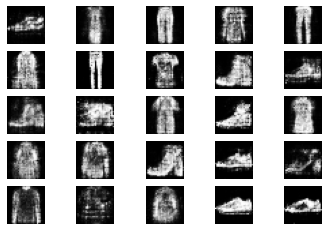

In [14]:
sample_images(epoch, show = 1)